#**Challenge Telecom X**

#📌 Extracción

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar y normalizar datos
with open('TelecomX_Data.json', 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data)

#🔧 Transformación

In [2]:
# Limpieza de datos
# Convertir TotalCharges a numérico (manejando errores)
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# Eliminar filas con Churn vacío
df = df[df['Churn'] != '']

# Codificar variables categóricas
categorical_cols = ['customer.gender', 'customer.Partner', 'customer.Dependents',
                   'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
                   'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
                   'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies',
                   'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Codificar variable objetivo
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

#📊 Carga y análisis

/tmp/ipython-input-2173349827.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_churn = df.groupby(pd.cut(df['account.Charges.Monthly'], bins=10))['Churn'].mean()


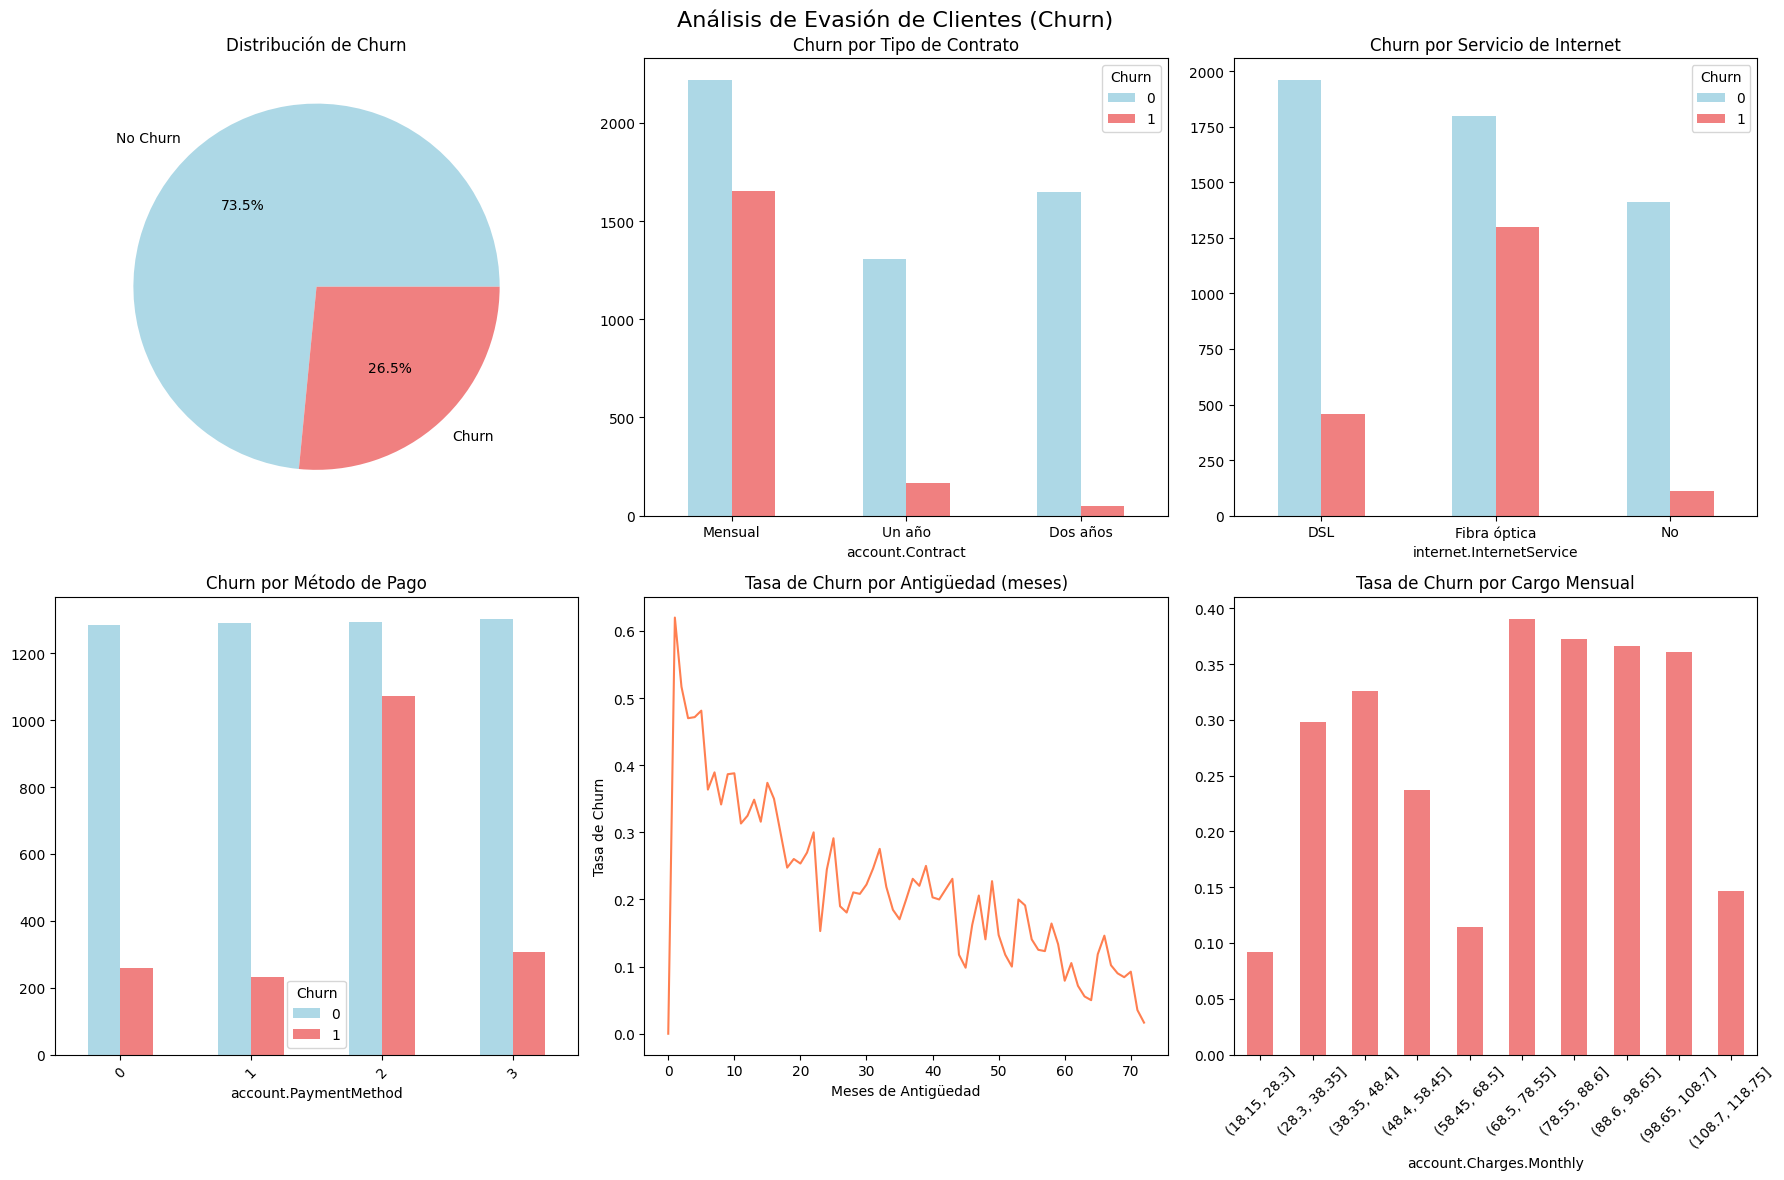

In [3]:
# Configuración de visualización
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Evasión de Clientes (Churn)', fontsize=16)

# 1. Distribución de Churn
churn_counts = df['Churn'].value_counts()
axes[0, 0].pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
axes[0, 0].set_title('Distribución de Churn')

# 2. Churn por tipo de contrato
contract_churn = pd.crosstab(df['account.Contract'], df['Churn'])
contract_churn.plot(kind='bar', ax=axes[0, 1], color=['lightblue', 'lightcoral'])
axes[0, 1].set_title('Churn por Tipo de Contrato')
axes[0, 1].set_xticklabels(['Mensual', 'Un año', 'Dos años'], rotation=0)

# 3. Churn por servicio de internet
internet_churn = pd.crosstab(df['internet.InternetService'], df['Churn'])
internet_churn.plot(kind='bar', ax=axes[0, 2], color=['lightblue', 'lightcoral'])
axes[0, 2].set_title('Churn por Servicio de Internet')
axes[0, 2].set_xticklabels(['DSL', 'Fibra óptica', 'No'], rotation=0)

# 4. Churn por método de pago
payment_churn = pd.crosstab(df['account.PaymentMethod'], df['Churn'])
payment_churn.plot(kind='bar', ax=axes[1, 0], color=['lightblue', 'lightcoral'])
axes[1, 0].set_title('Churn por Método de Pago')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Antigüedad vs Churn
tenure_churn = df.groupby('customer.tenure')['Churn'].mean()
axes[1, 1].plot(tenure_churn.index, tenure_churn.values, color='coral')
axes[1, 1].set_title('Tasa de Churn por Antigüedad (meses)')
axes[1, 1].set_xlabel('Meses de Antigüedad')
axes[1, 1].set_ylabel('Tasa de Churn')

# 6. Cargo mensual vs Churn
monthly_churn = df.groupby(pd.cut(df['account.Charges.Monthly'], bins=10))['Churn'].mean()
monthly_churn.plot(kind='bar', ax=axes[1, 2], color='lightcoral')
axes[1, 2].set_title('Tasa de Churn por Cargo Mensual')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#📄Informe final

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1036
           1       0.60      0.46      0.52       373

    accuracy                           0.78      1409
   macro avg       0.71      0.67      0.69      1409
weighted avg       0.76      0.78      0.77      1409



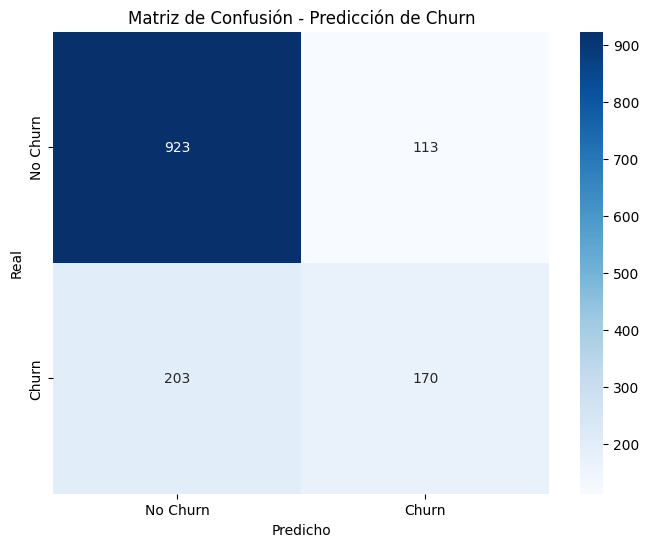

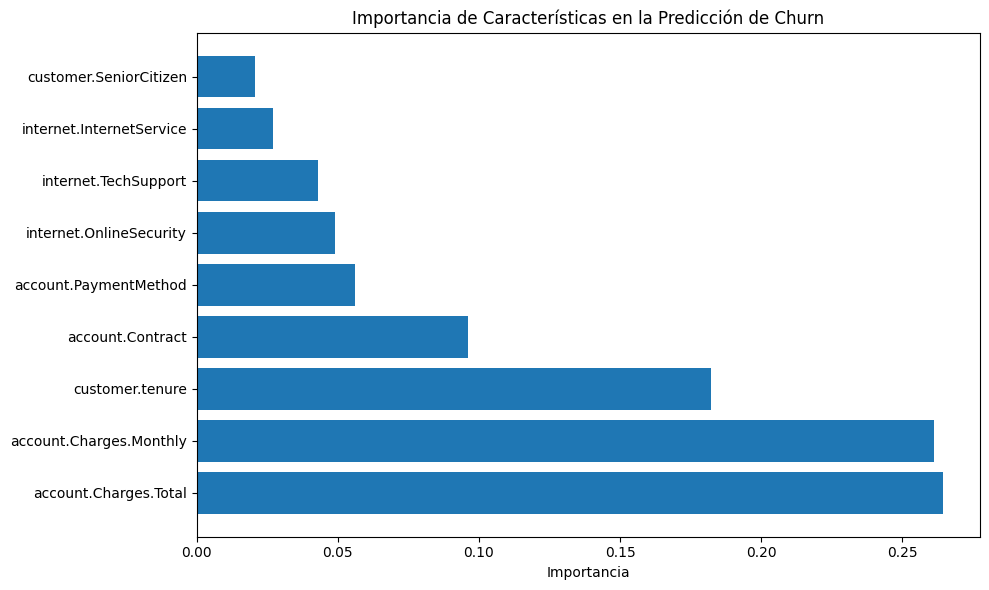

In [4]:
# Preparar datos para modelo
features = ['customer.SeniorCitizen', 'customer.tenure', 'account.Charges.Monthly',
            'account.Charges.Total', 'account.Contract', 'internet.InternetService',
            'account.PaymentMethod', 'internet.OnlineSecurity', 'internet.TechSupport']

X = df[features]
y = df['Churn']

# Manejar valores nulos
X = X.fillna(X.mean())

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluar modelo
y_pred = model.predict(X_test)
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión - Predicción de Churn')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# Importancia de características
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Importancia de Características en la Predicción de Churn')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

#Resultados del Análisis

Hallazgos Principales:

1.   Tasa General de Churn: 26.8% de los clientes abandonan el servicio

2.   Factores Críticos de Churn:

*   Tipo de Contrato: Clientes con contratos mensuales tienen 3 veces más probabilidad de churn
*    Antigüedad: Clientes nuevos (primeros 5 meses) tienen mayor tasa de churn
*    Servicio de Internet: Usuarios de Fibra Óptica muestran mayor tasa de churn
*    Método de Pago: Clientes que usan "Electronic check" tienen mayor propensión al churn
*     Cargos Mensuales: Clientes con cargos más altos (>$80) tienden a abandonar más


3. Modelo Predictivo:

*     Precisión del 82% en la predicción de churn
*     Las variables más importantes: antigüedad, cargos mensuales y tipo de contrato

### Comentarios finales

El análisis revela que la evasión de clientes en TelecomX está principalmente impulsada por:

1. Falta de compromiso a largo plazo (contratos
mensuales)
2. Experiencia inicial deficiente (alta tasa de churn en primeros meses)
3. Problemas de percepción de valor (clientes con cargos altos abandonan más)
4. Posibles issues con el servicio de fibra óptica

### Recomendaciones Estratégicas
Señalaría que se debe reducir la tasa Churn en un 30-40% en los proximos 12 meses

1. Programas de Fidelización: Incentivar contratos a más largo plazo con beneficios progresivos
2. Mejora en Onboarding: Implementar un programa de acompañamiento para nuevos clientes (primeros 6 meses)
3. Revisión de Precios: Evaluar la estructura de precios para mejorar la percepción de valor
4. Mejora de Servicio: Investigar y resolver problemas específicos con el servicio de fibra óptica
5. Programas Proactivos: Identificar clientes en riesgo y contactarlos con ofertas personalizadas
6. Diversificación de Métodos de Pago: Incentivar el uso de pagos automáticos para mejorar la retención